In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 

## 1. Data generation

Create a function for generating the data. Both the input u (noisy stimulus) and the target output y (identity of the stimulus) are one-dimensional. The input $u(t) \in \mathbb{R}^1$  is defined by:

$
u(t) = 
\begin{cases}
\bar{u} + \xi(t), & \text{if } 5 \le t \le 45 \\
\xi(t), & \text{otherwise}
\end{cases}
$ 

$\bar{u}$ is the stimulus strength, drawn uniformly from $\pm \frac{3.2}{100} ({1, 2, 4, 8, 16})$, and $\xi$ is background noise, drawn from a normal distribution with mean 0 and standard-deviation 0.03.

The stimulus strength is re-sampled for each trial, the noise is re-sampled for each time-step. The target y is defined as the sign of $\bar{u}$. Write your function such that it can generate multiple trials at the same time, this will be useful for training our network using stochastic gradient descent. Plot the data for several trials to make sure the labels match the inputs, and the noise levels are reasonable.

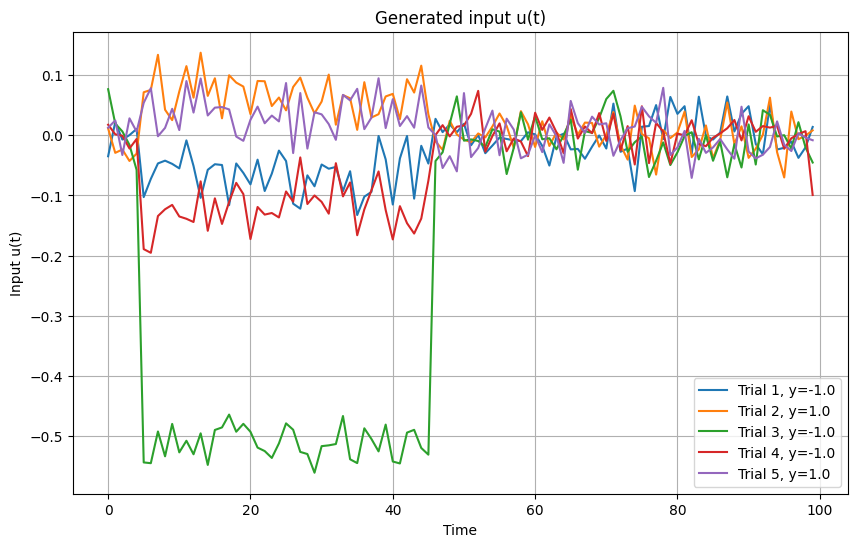

In [5]:
def create_input_data(time, noise_mean=0, noise_std=0.03):
    u = np.zeros(len(time))
    # stimulus strength, drawn uniformly from $\pm \frac{3.2}{100} {1, 2, 4, 8, 16}$
    positive_magnitudes = (3.2 / 100) * np.array([1, 2, 4, 8, 16])
    possible_stimulus_strengths = np.sort(np.concatenate([-positive_magnitudes, positive_magnitudes]))
    stimulus_strength = np.random.choice(possible_stimulus_strengths)
    for t in time:
        xi = np.random.normal(noise_mean, noise_std)
        # if t smaller equal 45, bigger equal 5
        if 5 <= t <= 45:
            u[t] = stimulus_strength + xi
        else:
            u[t] = xi
    y = np.sign(stimulus_strength)
    return u, y

def create_input_dataframe_multiple_trials(time, trials=100):
    data = []
    for _ in range(trials):
        u, y = create_input_data(time)
        data.append({'u': u, 'y': y})
    df = pd.DataFrame(data)
    return df

t = np.arange(0, 100)
input = create_input_dataframe_multiple_trials(t, trials=5)


plt.figure(figsize=(10, 6))
for i in range(len(input)):
    plt.plot(t, input['u'][i], label=f'Trial {i+1}, y={input["y"][i]}')
plt.xlabel('Time')
plt.ylabel('Input u(t)')
plt.title('Generated input u(t)')
plt.legend()
plt.grid(True)
plt.show()

## 2. Recurrent Neural Network Initialization

Implement the recurrent neural network in your favorite deep learning library. The network has one-dimensional inputs and outputs, and an arbitrary number N of recurrent units. Its trainable parameters are the left and right connectivity vectors m, n. It also has fixed input and output weights I and w, respectively. All (trainable and fixed) parameters are sampled from a standard normal distribution, with the exception of the output weights, which are drawn with standard deviation of 4 (why?). The dynamics of the ith unit are given by

$
\tau \frac{dx_i}{dt} = -x_i + \sum_{j=1}^N J_{ij} \phi(x_j) + I_i u(t), \quad i = 1, \ldots, N.
$

Here $\Phi= \tanh$ is the neuron’s transfer function, and $\tau = 100$ ms the neuronal time constant. Simulate the network using forward Euler with a time step of $\Delta t = 20$ ms (the stimulus duration of 75 time steps corresponds to 1500ms real time). The rank one matrix J is defined as

$
J = \frac{1}{N}\, \mathbf{m} \mathbf{n}^T
$

The network’s output is a linear readout of the rates:

$
z(t) = \frac{1}{N} \sum_{i=1}^N w_i \Phi(x_i)
$

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class RankOneRNN(nn.Module):
    def __init__(self, N):
        super(RankOneRNN, self).__init__()
        self.N = N
        self.m = nn.Parameter(torch.randn(N))
        self.n = nn.Parameter(torch.randn(N))
        self.I = torch.randn(N)  
        self.w = torch.randn(N) * 4  # std=4

        self.tau = 100
        self.dt = 20

    def forward(self, u_batch):  # u_batch: (B, T)
        B, T = u_batch.shape
        x = torch.zeros(B, self.N)  # initial hidden state
        z_out = []

        for t in range(T):
            phi_x = torch.tanh(x)  # (B, N)
            J_phi = (1 / self.N) * (phi_x @ self.n.unsqueeze(1)) * self.m  # rank-1
            u_t = u_batch[:, t]  # (B,)
            du = (-x + J_phi + self.I * u_t.unsqueeze(1)) * (self.dt / self.tau)
            x = x + du
            z_t = (1 / self.N) * (phi_x @ self.w)  # (B,)
            z_out.append(z_t)

        z_out = torch.stack(z_out, dim=1)  # shape: (B, T)
        return z_out

## 3. Training the network

Train a network of size N = 1281 by minimizing the mean squared error

$
\frac{1}{BT} \sum_{i, t} (z_i(t) - y_i(t))^2
$

using stochastic gradient descent. Here, the sum runs over all B trials in a mini-batch and the last T = 15 time steps (the target is only defined during this last ’decision epoch’). Use Adam with a learning rate of 5e-3 and a batch size of 32. The loss should converge to a value below 5e-2, which might require 1000 parameter updates. If the loss converges to higher values, debug your code by (1) overfitting the network on a single batch, and (2) training a full-rank network. Make sure to look at the the network’s input, output, and hidden dynamics once it has successfully converged.



In [15]:
# Settings
N = 1281
batch_size = 32
lr = 5e-3
T_total = 100
T_decision = 15
num_updates = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RankOneRNN(N).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

def get_batch(time, batch_size):
    df = create_input_dataframe_multiple_trials(time, trials=batch_size)
    u = np.stack(df['u'].values)  # (B, T)
    y = np.array(df['y'].values)  # (B,)
    return torch.tensor(u, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

losses = []
for step in range(num_updates):
    u_batch, y_batch = get_batch(np.arange(0, T_total), batch_size)
    u_batch = u_batch.to(device)
    y_batch = y_batch.to(device)

    z_batch = model(u_batch)  # shape: (B, T)
    z_decision = z_batch[:, -T_decision:]  # (B, T_decision)
    y_expanded = y_batch.unsqueeze(1).expand_as(z_decision)  # (B, T_decision)

    loss = loss_fn(z_decision, y_expanded)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss.item():.4f}")


Step 0, Loss: 1.0005
Step 100, Loss: 0.9997
Step 200, Loss: 0.9999
Step 300, Loss: 1.0000
Step 400, Loss: 1.0001
Step 500, Loss: 1.0004
Step 600, Loss: 0.9998
Step 700, Loss: 0.9964
Step 800, Loss: 0.0001
Step 900, Loss: 0.0000
